<a href="https://colab.research.google.com/github/engrsmukhtar/AI4EnergyProcessSystems/blob/AI4EPS-1/AI%20Models/Model%201/rankmod/backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Student Admissions with Neural Networks
In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

## Loading the data
To load the data and format it nicely, we will use two very useful packages called Pandas and Numpy. You can read on the documentation here:
- https://pandas.pydata.org/pandas-docs/stable/
- https://docs.scipy.org/

In [0]:
# Importing pandas and numpy
import pandas as pd
import numpy as np

# Reading the csv file into a pandas DataFrame
url = "https://raw.githubusercontent.com/engrsmukhtar/AI4EnergyProcessSystems/AI4EPS-1/AI%20Models/Model%201/student-admissions/Calciner%20-%20Duration-Temperature-CO2-CC.csv"
data = pd.read_csv(url)

# Printing out the first 10 rows of our data
data[:10]

,duration,temperature,co2
0,0.00,630.36,0.398463
1,1.00,632.75,0.406479
2,2.00,634.72,0.372648
3,3.00,636.50,0.358011
4,4.00,638.22,0.368520
5,5.00,640.87,0.390545
6,6.00,646.25,0.461572
7,7.00,661.58,0.842583
8,8.01,688.88,2.714227
9,9.01,711.10,4.844138


## Plotting the data

First let's make a plot of our data to see how it looks. In order to have a 2D plot, let's ingore the rank.

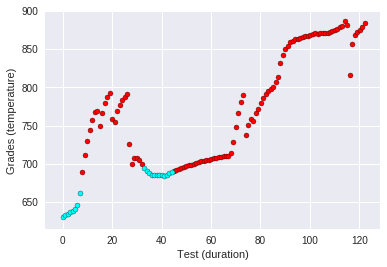

In [0]:
# Importing matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Function to help us plot
def plot_points(data):
    X = np.array(data[["duration","temperature"]])
    y = np.array(data["co2"])
    admitted = X[np.argwhere(y<=1.0)]
    rejected = X[np.argwhere(y>1.0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test (duration)')
    plt.ylabel('Grades (temperature)')
    
# Plotting the points
plot_points(data)
plt.show()

Roughly, it looks like the students with high scores in the grades and test passed, while the ones with low scores didn't, but the data is not as nicely separable as we hoped it would. Maybe it would help to take the rank into account? Let's make 4 plots, each one for each rank.

In [0]:
# Separating the ranks
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

# Plotting the graphs
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

This looks more promising, as it seems that the lower the rank, the higher the acceptance rate. Let's use the rank as one of our inputs. In order to do this, we should one-hot encode it.

## TODO: One-hot encoding the rank
Use the `get_dummies` function in pandas in order to one-hot encode the data.

Hint: To drop a column, it's suggested that you use `one_hot_data`[.drop( )](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html).

In [0]:
## One solution
# TODO:  Make dummy variables for rank and concat existing columns
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)

# Drop the previous rank column
one_hot_data = one_hot_data.drop('rank', axis=1)

# Print the first 10 rows of our data
one_hot_data[:10]

## TODO: Scaling the data
The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to handle. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [0]:
# Making a copy of our data
# processed_data = one_hot_data[:]
processed_data = pd.concat([data])

# TODO: Scale the columns
processed_data['duration'] = data['duration']/122.15 #processed_data['duration']/800
processed_data['temperature'] = data['temperature']/886.54
processed_data['co2'] = data['co2']/37.046161
processed_data[:10]

# Printing the first 10 rows of our procesed data
processed_data[:10]

,duration,temperature,co2
0,0.000000,0.711034,0.010756
1,0.008187,0.713730,0.010972
2,0.016373,0.715952,0.010059
3,0.024560,0.717960,0.009664
4,0.032747,0.719900,0.009948
5,0.040933,0.722889,0.010542
6,0.049120,0.728958,0.012459
7,0.057307,0.746249,0.022744
8,0.065575,0.777043,0.073266
9,0.073762,0.802107,0.130760


## Splitting the data into Training and Testing

In order to test our algorithm, we'll split the data into a Training and a Testing set. The size of the testing set will be 10% of the total data.

In [0]:
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 110
Number of testing samples is 13
    duration  temperature       co2
15  0.122964     0.845489  0.211695
79  0.647564     0.870711  0.228901
67  0.549161     0.801284  0.049922
95  0.778715     0.974530  0.949445
53  0.434466     0.789835  0.034284
33  0.270487     0.783507  0.026709
43  0.352436     0.775272  0.024187
99  0.811461     0.978817  0.990285
39  0.319689     0.773005  0.018846
97  0.795088     0.976786  0.970191
    duration  temperature       co2
3   0.024560     0.717960  0.009664
23  0.188539     0.876464  0.201693
28  0.229472     0.789801  0.185091
36  0.295047     0.773614  0.018387
45  0.368809     0.778803  0.027170
57  0.467212     0.794019  0.036959
71  0.581989     0.864394  0.340414
90  0.737700     0.958614  0.601136
92  0.754155     0.968811  0.820275
93  0.762341     0.971406  0.888242


## Splitting the data into features and targets (labels)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

In [0]:
features = train_data.drop('co2', axis=1)
targets = train_data['co2']
features_test = test_data.drop('co2', axis=1)
targets_test = test_data['co2']

print(features[:10])
print(targets[:10])

    duration  temperature
15  0.122964     0.845489
79  0.647564     0.870711
67  0.549161     0.801284
95  0.778715     0.974530
53  0.434466     0.789835
33  0.270487     0.783507
43  0.352436     0.775272
99  0.811461     0.978817
39  0.319689     0.773005
97  0.795088     0.976786
15    0.211695
79    0.228901
67    0.049922
95    0.949445
53    0.034284
33    0.026709
43    0.024187
99    0.990285
39    0.018846
97    0.970191
Name: co2, dtype: float64


## Training the 2-layer Neural Network
The following function trains the 2-layer neural network. First, we'll write some helper functions.

In [0]:
# Activation (sigmoid) function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_prime(x):
    return sigmoid(x) * (1-sigmoid(x))
def error_formula(y, output):
    return - y*np.log(output) - (1 - y) * np.log(1-output)

# TODO: Backpropagate the error
Now it's your turn to shine. Write the error term. Remember that this is given by the equation $$ (y-\hat{y}) \sigma'(x) $$

In [0]:
# TODO: Write the error term formula
def error_term_formula(x, y, output):
  
    return (y - output)*sigmoid_prime(x)

In [0]:
# Neural Network hyperparameters
epochs = 10005
learnrate = 0.02

# Training function
def train_nn(features, targets, epochs, learnrate):
    
    # Use to same seed to make debugging easier
    np.random.seed(42)

    n_records, n_features = features.shape
    last_loss = None

    # Initialize weights
    weights = np.random.normal(scale=1 / n_features**.5, size=n_features)

    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features.values, targets):
            # Loop through all records, x is the input, y is the target

            # Activation of the output unit
            #   Notice we multiply the inputs and the weights here 
            #   rather than storing h as a separate variable 
            output = sigmoid(np.dot(x, weights))

            # The error, the target minus the network output
            error = error_formula(y, output)

            # The error term
            error_term = error_term_formula(x, y, output)

            # The gradient descent step, the error times the gradient times the inputs
            del_w += error_term * x

        # Update the weights here. The learning rate times the 
        # change in weights, divided by the number of records to average
        weights += learnrate * del_w / n_records

        # Printing out the mean square error on the training set
        if e % (epochs / 10) == 0:
            out = sigmoid(np.dot(features, weights))
            loss = np.mean((out - targets) ** 2)
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            print("=========")
    print("Finished training!")
    return weights
    
weights = train_nn(features, targets, epochs, learnrate)

Epoch: 0
Train loss:  0.15105682358210995
Epoch: 2001
Train loss:  0.1221528235046718
Epoch: 4002
Train loss:  0.11328533354635922
Epoch: 6003
Train loss:  0.10577754979918183
Epoch: 8004
Train loss:  0.09942292279166798
Finished training!


## Calculating the Accuracy on the Test Data

In [0]:
# Calculate accuracy on test data
test_out = sigmoid(np.dot(features_test, weights))
predictions = test_out > 0.5
accuracy = np.mean(predictions == targets_test)
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.000
